# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
import datetime as dt
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import time
import os
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


# Read The Data
data = pd.read_csv('hotel-classification-dataset.csv')

# set X & Y
y = data.iloc[:, 16]
x = data.iloc[:, 0:16]

# Split Train_Test & Sentiment Analysis

In [5]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

from textblob import TextBlob

# Define a function to analyze the sentiment of a sentence
def get_sentiment(sentence):
    blob = TextBlob(sentence)
    return blob.sentiment.polarity

# Apply the sentiment analysis function to each row in the positive and negative columns
def apply_sentiment(data):
    data['positive_sentiment'] = data['Positive_Review'].apply(get_sentiment)
    data['negative_sentiment'] = data['Negative_Review'].apply(get_sentiment)
    return data

# Preprocessing

## Missing Values & Encoding

In [13]:
def split_Review_Date(data):
    # split Review_Date
    # df = pd.DataFrame()
    data['Review_Date'] = pd.to_datetime(data['Review_Date'])
    data['Year'] = data['Review_Date'].dt.year
    data['Month'] = data['Review_Date'].dt.month
    data['Day'] = data['Review_Date'].dt.day
    data = data.drop(["Review_Date"], axis=1)
    return data

def split_Tags_days_since(data):
    # split Tags
    Trip = []
    Members = []
    Room_Kind = []
    Nights = []
    the_way_of_submission = []
    Tags = list(data['Tags'])
    tag = []
    days = list(data['days_since_review'])
    days_final = []
    for i in range(len(Tags)):
        Tags[i] = Tags[i].replace("[", "")
        Tags[i] = Tags[i].replace("]", "")
        Tags[i] = Tags[i].replace("'", "")
        tag.append(Tags[i].split(","))
        # clean days_since review
        days[i] = str(days[i]).replace("days", "")
        days[i] = str(days[i]).replace("day", "")
        days_final.append(int(days[i]))
    for j in tag:
        trip = False
        mem = False
        room = False
        night = False
        submission = False
        for k in j:
            if k.__contains__("trip"):
                Trip.append(k)
                trip = True
            elif k.__contains__('room') or k.__contains__('Room'):
                Room_Kind.append(k)
                room = True
            elif (k.__contains__('Stayed')):
                result = ''.join(char for char in k if char.isdigit())
                Nights.append(int(result))
                night = True
            elif k.__contains__('Submitted'):
                the_way_of_submission.append(k)
                submission = True
            elif k.__contains__('Couple') or k.__contains__('Group') or k.__contains__('children') or k.__contains__(
                    'traveler'):
                Members.append(k)
                mem = True
        if not trip:
            Trip.append('no trip')
        if not room:
            Room_Kind.append('no room')
        if not night:
            Nights.append(0)
        if not submission:
            the_way_of_submission.append('not Submitted')
        if not mem:
            Members.append('no one')
    data['Trip'] = Trip
    data['Members'] = Members
    data['Room'] = Room_Kind
    data['Nights'] = Nights
    data['Submission'] = the_way_of_submission
    data = data.drop(['Tags'], axis=1)
    data['days_since_review'] = days_final
    return data

def data_cleaning_X_Train(X_train):

    X_train['Positive_Review'] = X_train['Positive_Review'].replace('No Positive', np.nan)
    X_train['Negative_Review'] = X_train['Negative_Review'].replace('No Negative', np.nan)

    # drop columns with all nan values
    X_train = X_train.dropna(axis=1, how="all")
    
    

    mean_list = []
    mean_list.append(X_train['Average_Score'].mean())
    mean_list.append(X_train['Total_Number_of_Reviews'].mean())  # ask
    mean_list.append(X_train['lat'].mean())
    mean_list.append(X_train['lng'].mean())
    
    # data with filling missing values (X_train)
    X_train = X_train.fillna({'Hotel_Address': 'no address', 'Additional_Number_of_Scoring': 0.0,
                              'Review_Date': "00/00/0000", 'Average_Score': mean_list[0], 'Hotel_Name': 'no name',
                              'Reviewer_Nationality': 'no info', 'Negative_Review': 'positive',
                              'Review_Total_Negative_Word_Counts': 0.0, 'Total_Number_of_Reviews': mean_list[1],
                              'Positive_Review': 'negative', 'Review_Total_Positive_Word_Counts': 0.0,
                              'Total_Number_of_Reviews_Reviewer_Has_Given': 0.0,
                              'Tags': "[' no trip ', ' no ', ' no Room ', ' 0 nights ', 'not Submitted']",
                              'days_since_review': '0 day', 'lat': mean_list[2], 'lng': mean_list[3]}) #, 'Reviewer_Score': 0.0})


    # split Review_Date
    X_train = split_Review_Date(X_train) # For X_train
    
    # split Tags
    X_train = split_Tags_days_since(X_train) # For X_train
    
    return X_train,mean_list

def data_cleaning_X_Test(X_test,mean_list):

    X_test['Positive_Review'] = X_test['Positive_Review'].replace('No Positive', np.nan)
    X_test['Negative_Review'] = X_test['Negative_Review'].replace('No Negative', np.nan)
    
    # drop columns with all nan values
    X_test = X_test.dropna(axis=1, how="all")
    
    # data with filling missing values (X_test)
    X_test = X_test.fillna({'Hotel_Address': 'no address', 'Additional_Number_of_Scoring': 0.0,
                            'Review_Date': "00/00/0000", 'Average_Score': mean_list[0], 'Hotel_Name': 'no name',
                            'Reviewer_Nationality': 'no info', 'Negative_Review': 'positive',
                            'Review_Total_Negative_Word_Counts': 0.0, 'Total_Number_of_Reviews': mean_list[1],
                            'Positive_Review': 'negative', 'Review_Total_Positive_Word_Counts': 0.0,
                            'Total_Number_of_Reviews_Reviewer_Has_Given': 0.0,
                            'Tags': "[' no trip ', ' no ', ' no Room ', ' 0 nights ', 'not Submitted']",
                            'days_since_review': '0 day', 'lat': mean_list[2], 'lng': mean_list[3]}) #, 'Reviewer_Score': 0.0})


    # split Review_Date
    X_test = split_Review_Date(X_test) # For X_train
    
    # split Tags
    X_test = split_Tags_days_since(X_test) # For X_train
    
    return X_test

# Handle The Missing Values In The Reviewer_Score With Tec: Predictive imputation
from sklearn.ensemble import RandomForestClassifier
def data_cleaning_Y_Train(X_train, y_train):
    # Combine X_train and y_train into one DataFrame
    df_train = pd.concat([X_train, y_train], axis=1)
    
    # Split the dataset into observations with and without missing values
    df_missing = df_train[df_train['Reviewer_Score'].isnull()]
    df_not_missing = df_train[~df_train['Reviewer_Score'].isnull()]

    # Separate the target variable from the other features
    X = df_not_missing.drop('Reviewer_Score', axis=1)
    y = df_not_missing['Reviewer_Score']

    # Train a random forest classifier on the training set
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Predict the missing target values using the trained random forest classifier
    missing_pred = rf.predict(df_missing.drop('Reviewer_Score', axis=1))

    # Impute the missing target values in the training set with the predicted values
    df_train.loc[df_train['Reviewer_Score'].isnull(), 'Reviewer_Score'] = missing_pred

    # Separate the imputed target variable from the other features
    y_train = df_train['Reviewer_Score']
    X_train = df_train.drop('Reviewer_Score', axis=1)

    return X_train, y_train,rf

def data_cleaning_Y_Test(X_test, y_test, rf):
    # Combine X_test and y_test into one DataFrame
    df_test = pd.concat([X_test, y_test], axis=1)
    
    # Split the dataset into observations with and without missing values
    df_missing = df_test[df_test['Reviewer_Score'].isnull()]
    df_not_missing = df_test[~df_test['Reviewer_Score'].isnull()]

    # Separate the target variable from the other features
    X = df_not_missing.drop('Reviewer_Score', axis=1)

    # Predict the missing target values using the trained random forest classifier
    missing_pred = rf.predict(X)

    # Impute the missing target values in the test set with the predicted values
    df_test.loc[df_test['Reviewer_Score'].isnull(), 'Reviewer_Score'] = missing_pred

    # Separate the imputed target variable from the other features
    y_test = df_test['Reviewer_Score']
    X_test = df_test.drop('Reviewer_Score', axis=1)

    return X_test, y_test


 from collections import defaultdict
 class Label_Encoder:
        def __init__(self):
            self.label_dict = defaultdict(int)
            self.label_count = 0

        def Fit_Or_Transform(self,labels):
            
            transformed = np.zeros(len(labels), dtype=int)

            for i, label in enumerate(labels):
                if label in self.label_dict:
                    transformed[i] = self.label_dict[label]
                else:
                    self.label_dict[label] = self.label_count
                    self.label_count += 1
                    transformed[i] = self.label_dict[label]

            return transformed



def data_encoding_X_Train(X_train):
    # Creating a instance of label Encoder.
    le = Label_Encoder()
    # printing label For (X_train) "Fit" and "Transform"
    X_train['Hotel_Name'] = le.Fit_Or_Transform(X_train['Hotel_Name'])
    X_train['Hotel_Address'] = le.Fit_Or_Transform(X_train['Hotel_Address'])
    X_train['Reviewer_Nationality'] = le.Fit_Or_Transform(X_train['Reviewer_Nationality'])
    X_train['Trip'] = le.Fit_Or_Transform(X_train['Trip'])
    X_train['Members'] = le.Fit_Or_Transform(X_train['Members'])
    X_train['Submission'] = le.Fit_Or_Transform(X_train['Submission'])
    X_train['Room'] = le.Fit_Or_Transform(X_train['Room'])
    
    return X_train,le

    
def data_encoding_X_Test(X_test,le):

    # printing label For (X_test) "Already Fitted" just "Transform"
    X_test['Hotel_Name'] = le.Fit_Or_Transform(X_test['Hotel_Name'])
    X_test['Hotel_Address'] = le.Fit_Or_Transform(X_test['Hotel_Address'])
    X_test['Reviewer_Nationality'] = le.Fit_Or_Transform(X_test['Reviewer_Nationality'])
    X_test['Trip'] = le.Fit_Or_Transform(X_test['Trip'])
    X_test['Members'] = le.Fit_Or_Transform(X_test['Members'])
    X_test['Submission'] = le.Fit_Or_Transform(X_test['Submission'])
    X_test['Room'] = le.Fit_Or_Transform(X_test['Room'])

    return X_test

def data_encoding_Y_Train(y_train):
    #the predict Column
    
    # Oridinal Encoding
    categories_order = ['Low_Reviewer_Score', 'Intermediate_Reviewer_Score','High_Reviewer_Score']
    # create an instance of OrdinalEncoder with the defined categories order
    ordinal_encoder = OrdinalEncoder(categories=[categories_order])
    # encode the data using the ordinal encoder (y_Train) "Fit" and "Transform"
    y_train_encoded = ordinal_encoder.fit_transform(y_train.values.reshape(-1, 1))
    y_train_encoded = pd.Series(y_train_encoded.reshape(-1), index= y_train.index)

    return y_train_encoded,ordinal_encoder

def data_encoding_Y_Test(y_test,ordinal_encoder):
    
    # encode the data using the ordinal encoder (y_Test) "already Fitted" just "Transform"
    y_test_encoded = ordinal_encoder.transform(y_test.values.reshape(-1, 1))
    y_test_encoded = pd.Series(y_test_encoded.reshape(-1), index= y_test.index)

    return y_test_encoded

## Scaling

In [16]:
def standard(x):
    scaler = StandardScaler()
    cols=x.columns
    x = scaler.fit_transform(x)  # calc mean and standard division
    x = pd.DataFrame(x, columns= cols)
    return x,scaler

def norm(x):
    scaler = MinMaxScaler()
    cols=x.columns
    scaler.fit_transform(x)  # calc X_max and X_min
    # # X_norm = (X_old - X_min) / (X_max - X_min)
    x = pd.DataFrame(x, columns= cols)
    return x,scaler

def scaling(x, IsTrain,IsStandard=None,scaler=None):
    if (IsTrain == True):
        if (IsStandard == True):
            x,scaler = standard(x)
        else:
            x,scaler = norm(x)        
        return x,scaler
    
    else: # this is test
        cols = x.columns
        x = scaler.transform(x)  # calc mean and standard division (Standard) Or calc X_max and X_min (Norm)
        x = pd.DataFrame(x, columns= cols)
        return x

## Handle Outliers

In [17]:
def trimming(data, name, upper_limit, lower_limit):
    update_data = data.loc[(data[name] <= upper_limit) & (data[name] >= lower_limit)]
    return update_data

def capping(data, name, upper_limit, lower_limit):
    new_data = data.copy()
    new_data.loc[data[name] > upper_limit, name] = upper_limit
    new_data.loc[data[name] < lower_limit, name] = lower_limit
    return new_data

def IQR(data, type):
    # method2 : IQR
    n = len(data.columns)
    for i in range(n):
        name = data.columns[i]
        q1 = data[name].quantile(0.25)
        q3 = data[name].quantile(0.75)
        iqr = q3 - q1
        upper_limit = q3 + 1.5 * iqr
        lower_limit = q1 - 1.5 * iqr
        # rmoval function
        if (type == 1):
            data = capping(data, name, upper_limit, lower_limit)
        elif (type == 2):
            data = trimming(data, name, upper_limit, lower_limit)
    return data

def z_score(data, type):
    n = len(data.columns)
    for i in range(n):
        name = data.columns[i]
        upper_limit = data[name].mean() + 3 * data[name].std()
        lower_limit = data[name].mean() - 3 * data[name].std()
        # rmoval function
        if (type == 1):
            data = capping(data, name, upper_limit, lower_limit)
        elif (type == 2):
            data = trimming(data, name, upper_limit, lower_limit)
    return data

def percentile(data, type):
    # method2 : IQR
    n = len(data.columns)
    for i in range(n):
        name = data.columns[i]
        upper_limit = data[name].quantile(0.99)
        lower_limit = data[name].quantile(0.01)
        # rmoval function
        if (type == 1):
            data = capping(data, name, upper_limit, lower_limit)
        elif (type == 2):
            data = trimming(data, name, upper_limit, lower_limit)
    return data

def handle_outliers(data, method, type):
    if (method == 'iqr'):
        data = IQR(data, type)
    elif (method == 'p'):
        data = percentile(data, type)
    elif (method == 'z'):
        data = z_score(data, type)
    return data

## Feature Selection 

In [25]:
from sklearn.feature_selection import VarianceThreshold

def ANOVA_ftest(x, y):
    fs = SelectKBest(score_func=f_classif, k=4)
    # fs = SelectKBest(score_func=mutual_info_classif, k=4)
    fs.fit(x, y.values.ravel())
    # transform train input data
    X_train_fs = fs.transform(x)
    np.seterr(invalid='ignore')
    for i in range(len(fs.scores_)):
        print('Feature %d: %f' % (i, fs.scores_[i]))
    selected_features = x.columns[fs.get_support()]
    x = x[selected_features]
    return x, y

def feature_selection(x, y):
    constant_filter = VarianceThreshold(threshold=0)

    # Fit and transforming on train data
    data_constant = constant_filter.fit_transform(x)

    # Extracting all constant columns using get support function of our filter
    constant_columns = [column for column in x.columns if column not in x.columns[constant_filter.get_support()]]
    x = x.drop(constant_columns, axis=1)
    qcons_filter = VarianceThreshold(threshold=0.01)

    # Fit and transforming on train data
    data_qcons = qcons_filter.fit_transform(x)

    # Extracting all Quasi constant columns using get support function of our filter
    qcons_columns = [column for column in x.columns if column not in x.columns[qcons_filter.get_support()]]
    x = x.drop(qcons_columns, axis=1)

    # check duplicated
    '''data_qcons_t = x.T
    data_qcons_t.shape
    x = data_qcons_t.drop_duplicates(keep='first').T'''
    # x = x.astype('int')
    x, y = ANOVA_ftest(x, y)
    return x, y

# Save & Load Model

In [ ]:
def save_model(model, filename):
    filename ='Models'+'/'+ filename
    # Check if the file exists
    if os.path.exists(filename):
        # oberwrite the model to file
        joblib.dump(model, filename)
        print(f"Model Overwrited to '{filename}'.")
    else:
        # Save the model to file
        joblib.dump(model, filename)
        print(f"Model saved to '{filename}'.")

def load_model(filename):
    filename ='Models'+'/'+ filename
    # Check if the file exists
    if os.path.exists(filename):
        # Load the model from file
        model = joblib.load(filename)
        print(f"Model loaded from '{filename}'.")
        return model
    else:
        print(f"File '{filename}' does not exist.")
        return None

# Accuracy & Confusion Matrix

In [29]:
def Print_Accuracy(model,X_data,y_data,data_name):
    print("--------------------------------------------------")
    # Use the classifier to make predictions on the test data
    predictions = model.predict(X_data)
    accuracy = accuracy_score(y_data , predictions)
    print(f"{str(model)}: {data_name} accuracy: {accuracy:.2%}")
    print("--------------------------------------------------")
    return predictions

def Display_Confusion_Matrix(y_data, predictions_data,model_name):
    ### import seaborn as sns
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_data, predictions_data)

    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(model_name)
    plt.show()
    return

# Preprocess Train Data

In [30]:
# Apply Sentiment Analysis
X_train = apply_sentiment(X_train)

# Clean data and Handle missing values
X_train,mean_list = data_cleaning_X_Train(X_train)
save_model(mean_list, 'Mean List.pkl')

# Encoding Some Features With Label Encoding
X_train,le = data_encoding_X_Train(X_train)
save_model(le, 'Label Encoder.pkl')

#Drop 'Positive_Review' & 'Negative_Review' In X_Train
X_train = X_train.drop(['Positive_Review'], axis=1)
X_train = X_train.drop(['Negative_Review'], axis=1)

# Handle Missing Value of The Reviewer_Score (y_train)  Classifier with Random Forset
X_train,y_train,rf = data_cleaning_Y_Train(X_train,y_train)
save_model(rf, 'Filling Missing Values_RF.pkl')

# Encoding The Reviewer_Score (y_train)  With Ordinal Encoder
y_train,ordinal_encoder = data_encoding_Y_Train(y_train)
save_model(ordinal_encoder, 'Ordinal Encoder.pkl')

# Handle Outliers
X_train = handle_outliers(X_train, 'iqr', 1)

#Scaling X_Train
X_train,scaler=scaling(X_train,IsTrain=True, IsStandard=True) # First: True is X_train ,, Second: True -> is (Standard) or not -> (Norm)
save_model(scaler, 'Standard Scaler.pkl')

# select the most effiective Features
X_train, y_train = feature_selection(X_train, y_train)
y_train=y_train.values
# reshape a 1D numpy array into a 2D numpy array. 
y_train = y_train[:, np.newaxis]
save_model(X_train.columns, 'Train_Cols_Feature_Selection.pkl')


Model Overwrited to 'Mean List.pkl'.
Model Overwrited to 'Label Encoder.pkl'.
Model Overwrited to 'Filling Missing Values_RF.pkl'.
Model Overwrited to 'Ordinal Encoder.pkl'.
Model Overwrited to 'Standard Scaler.pkl'.
Feature 0: 97.584116
Feature 1: 149.578975
Feature 2: 8051.581057
Feature 3: 98.450692
Feature 4: 302.616914
Feature 5: 10041.056463
Feature 6: 338.937412
Feature 7: 4341.123787
Feature 8: 101.112258
Feature 9: 13.502812
Feature 10: 64.594320
Feature 11: 51.326713
Feature 12: 4034.526292
Feature 13: 4292.951277
Feature 14: 20.316012
Feature 15: 63.988713
Feature 16: 0.198119
Feature 17: 289.874194
Feature 18: 13.272485
Feature 19: 16.058170
Feature 20: 57.046971
Model Overwrited to 'Train_Cols_Feature_Selection.pkl'.


# Models

## SVM Model

In [31]:
'''
from sklearn import svm

# Create an SVM classifier
c = 0.001; #Svm Regularzition Parameter 
svm = svm.SVC(kernel='poly',degree=5)

# Fit the classifier to the training data
start = time.perf_counter()
svm.fit(X_train, y_train.ravel())
end = time.perf_counter()
print("SVM Model Time  : " + str(end - start) + " sec")

# Save model to file
save_model(svm, 'SVM_Model.pkl')

# Calculate accuracy on train data
predictions_train=Print_Accuracy(svm,X_train,y_train,data_name=train)

# Compute the confusion matrix (Test) 
Display_Confusion_Matrix(y_data= y_train, predictions_data= predictions_train ,model_name= "SVM_Model")
'''



'\nfrom sklearn import svm\n\n# Create an SVM classifier\nc = 0.001; #Svm Regularzition Parameter \nsvm = svm.SVC(kernel=\'poly\',degree=5)\n\n# Fit the classifier to the training data\nstart = time.perf_counter()\nsvm.fit(X_train, y_train.ravel())\nend = time.perf_counter()\nprint("SVM Model Time  : " + str(end - start) + " sec")\n\n# Save model to file\nsave_model(svm, \'SVM_Model.pkl\')\n\n# Calculate accuracy on train data\npredictions_train=Print_Accuracy(svm,X_train,y_train,data_name=train)\n\n# Compute the confusion matrix (Test) \nDisplay_Confusion_Matrix(y_data= y_train, predictions_data= predictions_train ,model_name= "SVM_Model")\n'

## Logistic Regression Model

Logistic Regress Model Time  : 0.34952400001930073 sec
Model Overwrited to 'Logistic_Regress.pkl'.
--------------------------------------------------
train accuracy: 70.83%
--------------------------------------------------


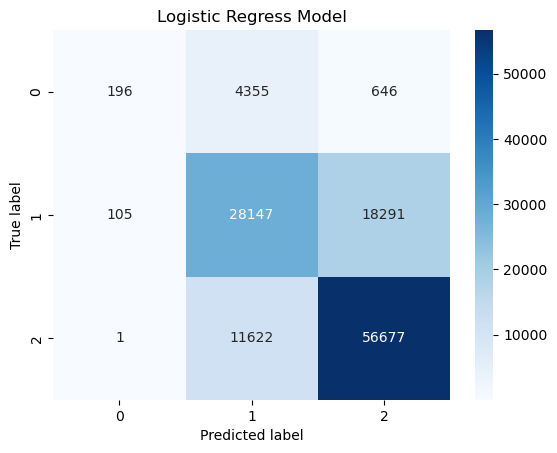

In [32]:
# Create a Logistic Regression classifier
lr = LogisticRegression(max_iter=1000)

# Fit the classifier to the training data
start = time.perf_counter()
lr.fit(X_train, y_train.ravel())
end = time.perf_counter()
print("Logistic Regress Model Time  : " + str(end - start) + " sec")

# Save model to file
save_model(lr, 'Logistic_Regress.pkl')

# Calculate accuracy on train data
predictions_train=Print_Accuracy(lr,X_train,y_train,data_name="train")

# Compute the confusion matrix (Test) 
Display_Confusion_Matrix(y_data= y_train, predictions_data= predictions_train ,model_name= "Logistic Regress Model")

## Decision Tree Model

Decision Trees Model Time  : 0.16876669999328442 sec
Model Overwrited to 'Decision_Tree.pkl'.
--------------------------------------------------
train accuracy: 71.78%
--------------------------------------------------


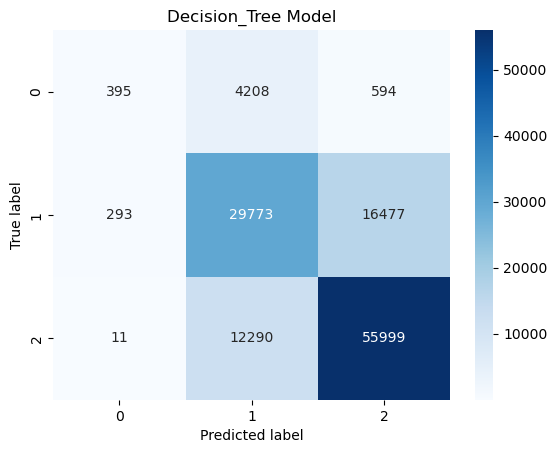

In [33]:
from sklearn.tree import DecisionTreeClassifier

# Create an instance of the DecisionTreeClassifier class
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=500)

# Fit the classifier to the training data
start = time.perf_counter()
dt.fit(X_train, y_train)
end = time.perf_counter()
print("Decision Trees Model Time  : " + str(end - start) + " sec")

# Save model to file
save_model(dt, 'Decision_Tree.pkl')

# Calculate accuracy on train data
predictions_train=Print_Accuracy(dt,X_train,y_train,data_name="train")

# Compute the confusion matrix (Test) 
Display_Confusion_Matrix(y_data= y_train, predictions_data= predictions_train ,model_name= "Decision_Tree Model")

## RandomForestClassifier

RandomForest Classifier Model Time  : 7.1980361999885645 sec
Model Overwrited to 'RandomForestClassifier.pkl'.
--------------------------------------------------
train accuracy: 73.04%
--------------------------------------------------


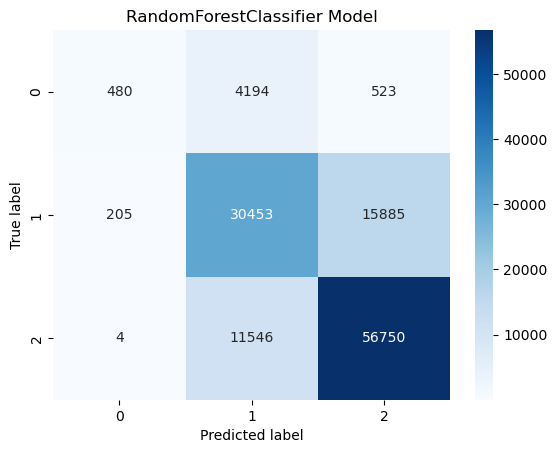

In [34]:
# Define the hyperparameters to try
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Use grid search to find the best hyperparameters
#grid_search = GridSearchCV(rf, param_grid, cv=5)
#grid_search.fit(X_train, y_train.ravel())

# Print the best hyperparameters and the corresponding score
#print('Best hyperparameters:', grid_search.best_params_)
#print('Best score:', grid_search.best_score_)

# Use the best model to make predictions on the testing data
#best_model = grid_search.best_estimator_
#predictions_test = best_model.predict(X_test)

# Create the random forest classifier with some hyperparameters
#rf = RandomForestClassifier(max_depth= 10, min_samples_leaf= 4, min_samples_split= 10, n_estimators= 100)
rf = RandomForestClassifier(n_estimators=100, max_depth=10)

# Fit the random forest model to the training data
start = time.perf_counter()
rf.fit(X_train, y_train.ravel())
end = time.perf_counter()
print("RandomForest Classifier Model Time  : " + str(end - start) + " sec")

# Save model to file
save_model(rf, 'RandomForestClassifier.pkl')

# Calculate accuracy on train data
predictions_train=Print_Accuracy(rf,X_train,y_train,data_name="train")

# Compute the confusion matrix (Test) 
Display_Confusion_Matrix(y_data= y_train, predictions_data= predictions_train ,model_name= "RandomForestClassifier Model")

# ================================

# Test Script

## Preparing The Test

In [35]:
# Read The Test Data
#test_data = pd.read_csv('hotel-classification-dataset.csv')

# set test_X & test_Y
#y_test = data.iloc[:, 16]
#X_test = data.iloc[:, 0:16]


# Apply Sentiment Analysis
X_test = apply_sentiment(X_test)

# Clean data and Handle missing values
load_mean_list= load_model('Mean List.pkl')
X_test = data_cleaning_X_Test(X_test,load_mean_list)


# Encoding Some Features With Label Encoding
load_le= load_model('Label Encoder.pkl')
X_test = data_encoding_X_Test(X_test,load_le)


#Drop 'Positive_Review' & 'Negative_Review' In X_Test
X_test = X_test.drop(['Positive_Review'], axis=1)
X_test = X_test.drop(['Negative_Review'], axis=1)

# Handle Missing Value of The Reviewer_Score  (y_test) Classifier with 
load_missing_rf= load_model('Filling Missing Values_RF.pkl')
X_test,y_test = data_cleaning_Y_Test(X_test,y_test,load_missing_rf)

# Encoding The Reviewer_Score  (y_test) With Ordinal Encoder
load_ordinal_encoder= load_model('Ordinal Encoder.pkl')
y_test = data_encoding_Y_Test(y_test,load_ordinal_encoder)

# Handle Outliers
X_test = handle_outliers(X_test, 'iqr', 1)

#Scaling X_Test
load_scaler= load_model('Standard Scaler.pkl')
X_test=scaling(X_test,IsTrain= False,scaler= load_scaler) # False is X_test..

# get column names of X_train
#train_cols = X_train.columns
train_cols = load_model('Train_Cols_Feature_Selection.pkl')

# select only the columns present in X_train in X_test
X_test = X_test.loc[:, train_cols]

Model loaded from 'Mean List.pkl'.
Model loaded from 'Label Encoder.pkl'.
Model loaded from 'Filling Missing Values_RF.pkl'.
Model loaded from 'Ordinal Encoder.pkl'.
Model loaded from 'Standard Scaler.pkl'.
Model loaded from 'Train_Cols_Feature_Selection.pkl'.


## Calculate Accuracy On (Test)

C:\Users\kirlo\anaconda3\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator SVC from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Model loaded from 'SVM_Model.pkl'.
Model loaded from 'Logistic_Regress.pkl'.
Model loaded from 'Decision_Tree.pkl'.
Model loaded from 'RandomForestClassifier.pkl'.
--------------------------------------------------
test accuracy: 71.47%
--------------------------------------------------


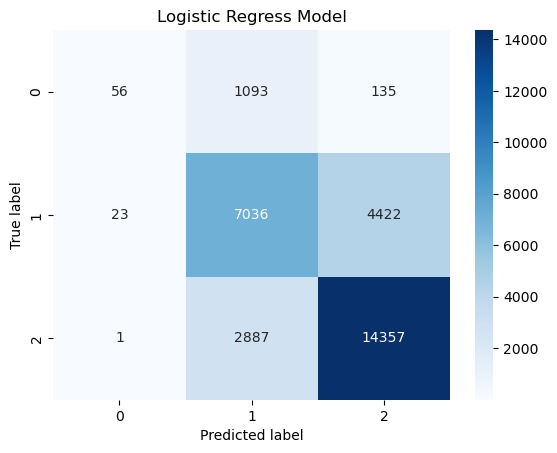

--------------------------------------------------
test accuracy: 71.46%
--------------------------------------------------


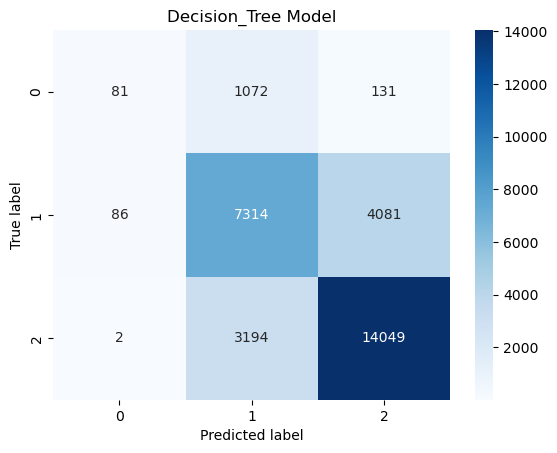

--------------------------------------------------
test accuracy: 72.02%
--------------------------------------------------


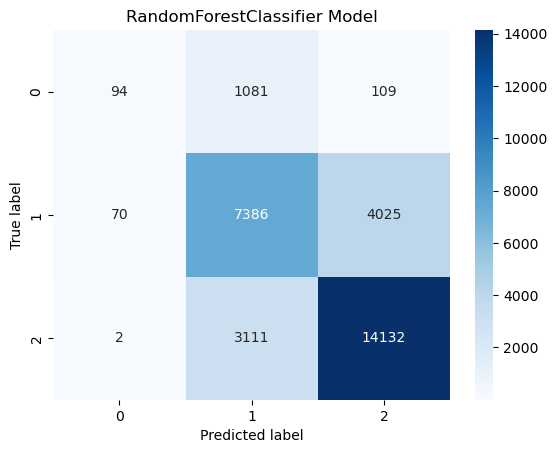

In [36]:
# Load the models
loaded_svm = load_model('SVM_Model.pkl')
load_lr = load_model('Logistic_Regress.pkl')
loaded_dt= load_model('Decision_Tree.pkl')
loaded_rf = load_model('RandomForestClassifier.pkl')

# Calculate accuracy on test data && Confusion_Matrix

#predictions_test=Print_Accuracy(loaded_svm,X_test,y_test,data_name="test")
#Display_Confusion_Matrix(y_data= y_test, predictions_data= predictions_test ,model_name= "SVM_Model")

predictions_test=Print_Accuracy(load_lr,X_test,y_test,data_name="test")
Display_Confusion_Matrix(y_data= y_test, predictions_data= predictions_test ,model_name= "Logistic Regress Model")

predictions_test=Print_Accuracy(loaded_dt,X_test,y_test,data_name="test")
Display_Confusion_Matrix(y_data= y_test, predictions_data= predictions_test ,model_name= "Decision_Tree Model")

predictions_test=Print_Accuracy(loaded_rf,X_test,y_test,data_name="test")
Display_Confusion_Matrix(y_data= y_test, predictions_data= predictions_test ,model_name= "RandomForestClassifier Model")